In [1]:
import numpy as np
import sound_field_analysis as sfa
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import griddata, interp1d
from functools import partial, reduce
from itertools import starmap, product, accumulate
from tqdm import tqdm
from spaudiopy.sph import inverse_sht
from librosa.display import specshow

from graph import points2graph, plus_freq_dim
from toa import smooth_toa, simplices2edges
from utils import sht_lstsq_reg, wrap, delay2phase, phase2delay
from kamui import unwrap_arbitrary

fatal: not a git repository (or any of the parent directories): .git


## Helper functions

In [2]:
def plot_sphere(az, col, v, resolution=100):
    target_az = np.linspace(0, 2 * np.pi, resolution * 2)
    target_col = np.linspace(0, np.pi, resolution)

    az = np.concatenate((az - 2 * np.pi, az, az + 2 * np.pi))
    col = np.concatenate((col, col, col))
    v = np.concatenate((v, v, v))

    interp = griddata(
        (az, col), v, (target_az[None, :], target_col[:, None]), method="cubic"
    ).reshape((resolution, resolution * 2))
    plt.imshow(interp, origin="lower")


def plot_plane(ax, az, col, values, target_col=90, tol=1, resolution=100, **kwargs):
    minimimum_col = (target_col - tol) * np.pi / 180
    maximum_col = (target_col + tol) * np.pi / 180
    mask = (col > minimimum_col) & (col < maximum_col)
    az = az[mask]
    col = col[mask]
    values = values[mask]

    az = np.concatenate((az - 2 * np.pi, az, az + 2 * np.pi))
    values = np.concatenate((values, values, values), axis=0)

    target_az = np.linspace(0, 2 * np.pi, resolution)
    interp = interp1d(az, values, kind="nearest", axis=0)(target_az)
    ax.imshow(interp.T, origin="lower", aspect="auto", **kwargs)

def plot_lateral_plane(ax, az, col, values, target_az=0, max_col=90, tol=1, resolution=100, **kwargs):
    minimimum_az = (target_az - tol) * np.pi / 180
    maximum_az = (target_az + tol) * np.pi / 180
    mask = (az > minimimum_az) & (az < maximum_az)
    # az = az[mask]
    col1 = col[mask]
    values1 = values[mask]

    # upside direction
    mask2 = (az > ((minimimum_az + np.pi) % (2 * np.pi))) & (az < (maximum_az + np.pi) % (2 * np.pi))
    col2 = -col[mask2]
    values2 = values[mask2]

    col = np.concatenate((col1, col2))
    values = np.concatenate((values1, values2), axis=0)

    max_col = max_col * np.pi / 180

    target_col = np.linspace(-max_col, max_col, resolution)
    interp = interp1d(col, values, kind="nearest", axis=0)(target_col)
    ax.imshow(interp.T, origin="lower", aspect="auto", **kwargs)

Read KEMAR HRTFs, calculated the TOA for time aligned, and prepare the graph structure for PU.

In [3]:
hrir_file = "KEMAR_Knowl_EarSim_SmallEars_FreeFieldComp_44kHz.sofa"
hrir_data = sfa.io.read_SOFA_file(hrir_file)
sr = hrir_data.l.fs
az = hrir_data.grid.azimuth
col = hrir_data.grid.colatitude
radius = hrir_data.grid.radius
hrir = np.stack((hrir_data.l.signal, hrir_data.r.signal), axis=1)
left_hrir = hrir_data.l.signal
hrir_xyz = sfa.utils.sph2cart((az, col, radius)).T
xyz = hrir_xyz / np.linalg.norm(hrir_xyz, axis=1, keepdims=True)

G, simplices = points2graph(hrir_xyz, True)
edges = np.array(G.edges)

toa, *_ = smooth_toa(
    hrir,
    hrir_xyz,
    sr,
    "edgelist",
    oversampling=10,
    ignore_toa=True,
    ignore_cross=True,
    weighted=True,
    # toa_weight=0.1,
)
left_toa = toa[:, 0]

left_hrtf = np.fft.rfft(left_hrir, axis=-1)
nfft = left_hrir.shape[-1]
freqs = np.arange(left_hrtf.shape[-1]) * sr / nfft
print(left_hrtf.shape, freqs.shape)


G_psi = plus_freq_dim(G, freqs.shape[0])
G_psi_edges = np.array(G_psi.edges)
# phase = np.angle(hrtf)



open SOFA file "KEMAR_Knowl_EarSim_SmallEars_FreeFieldComp_44kHz.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 828, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0
Size of the bottom simplex: 72
Size of the bottom simplex: 72
Number of sphere simplices: 1583
Number of sphere edges: 2409
TOA correlation: max=0.9945917572467935, min=0.5729892364991754
TOA delay: max=[1.24036281 1.16553288] ms, min=[0.50340136 0.51927438] ms
Cross correlation: max=0.9804526182710035, min=0.30732189811210475
Cross delay: max=0.7845804988662132 ms, min=-0.8095238095238095 ms
Left grid correlation: max=0.9999910565424174, min=0.5273580686587144
Left grid delay: max=0.11111111111111112 ms, min=-0.12698412698412698 ms
Right grid correlation: max=0.9999573309050428, min=0.5666618333636414
Right grid delay: max=0.11111111111111112 ms, min=-0.14285714285714288 ms
(828, 129) (129,)


Align left ear HRTFs in the frequency domain.

In [4]:
shift_toa = left_toa - left_toa.min()
shifter = np.exp(2j * np.pi * freqs / sr * shift_toa[:, None])
linear_phase = delay2phase(shift_toa[:, None], freqs, sr)
aligned_left_hrtf = left_hrtf * shifter
aligned_phase = np.angle(aligned_left_hrtf)
phase = np.angle(left_hrtf)

Define different unwrapping functions, corresponding to three different methods in the AES paper.

In [5]:
# Section 3.1
unwrap_freqs = partial(np.unwrap, axis=-1)
unwrap_spherical = partial(unwrap_arbitrary, edges=edges)

# Section 3.2
def unwrap_sphericals(wrapped_phase):
    unwrapped_spheres = map(unwrap_spherical, wrapped_phase.T)
    joint_unwrapped = np.stack(
        list(
            tqdm(
                accumulate(
                    unwrapped_spheres,
                    lambda prev, curr: curr + np.median(prev + wrap(curr - prev) - curr),
                )
            )
        ),
        axis=1,
    )
    return joint_unwrapped

# Section 3.3
unwrap_sphericals_freqs = lambda wrapped_phase: unwrap_arbitrary(
    wrapped_phase.T.reshape(-1),
    edges=G_psi_edges,
).reshape(wrapped_phase.shape[1], -1).T

Add back the linear phase component (the TOA) to the unwrapped phase.

In [6]:
results = {
    "freqs": unwrap_freqs(phase),
    "spherical": unwrap_sphericals(aligned_phase) + linear_phase,
    "spherical_freqs": unwrap_sphericals_freqs(aligned_phase) + linear_phase,
}

129it [00:03, 36.22it/s]


In [7]:
np.savez("sonicom_unwrapped_phase.npz", **results)
results = np.load("sonicom_unwrapped_phase.npz")

## Plot phase delays

Corresponding to Figure 4 in the AES paper.

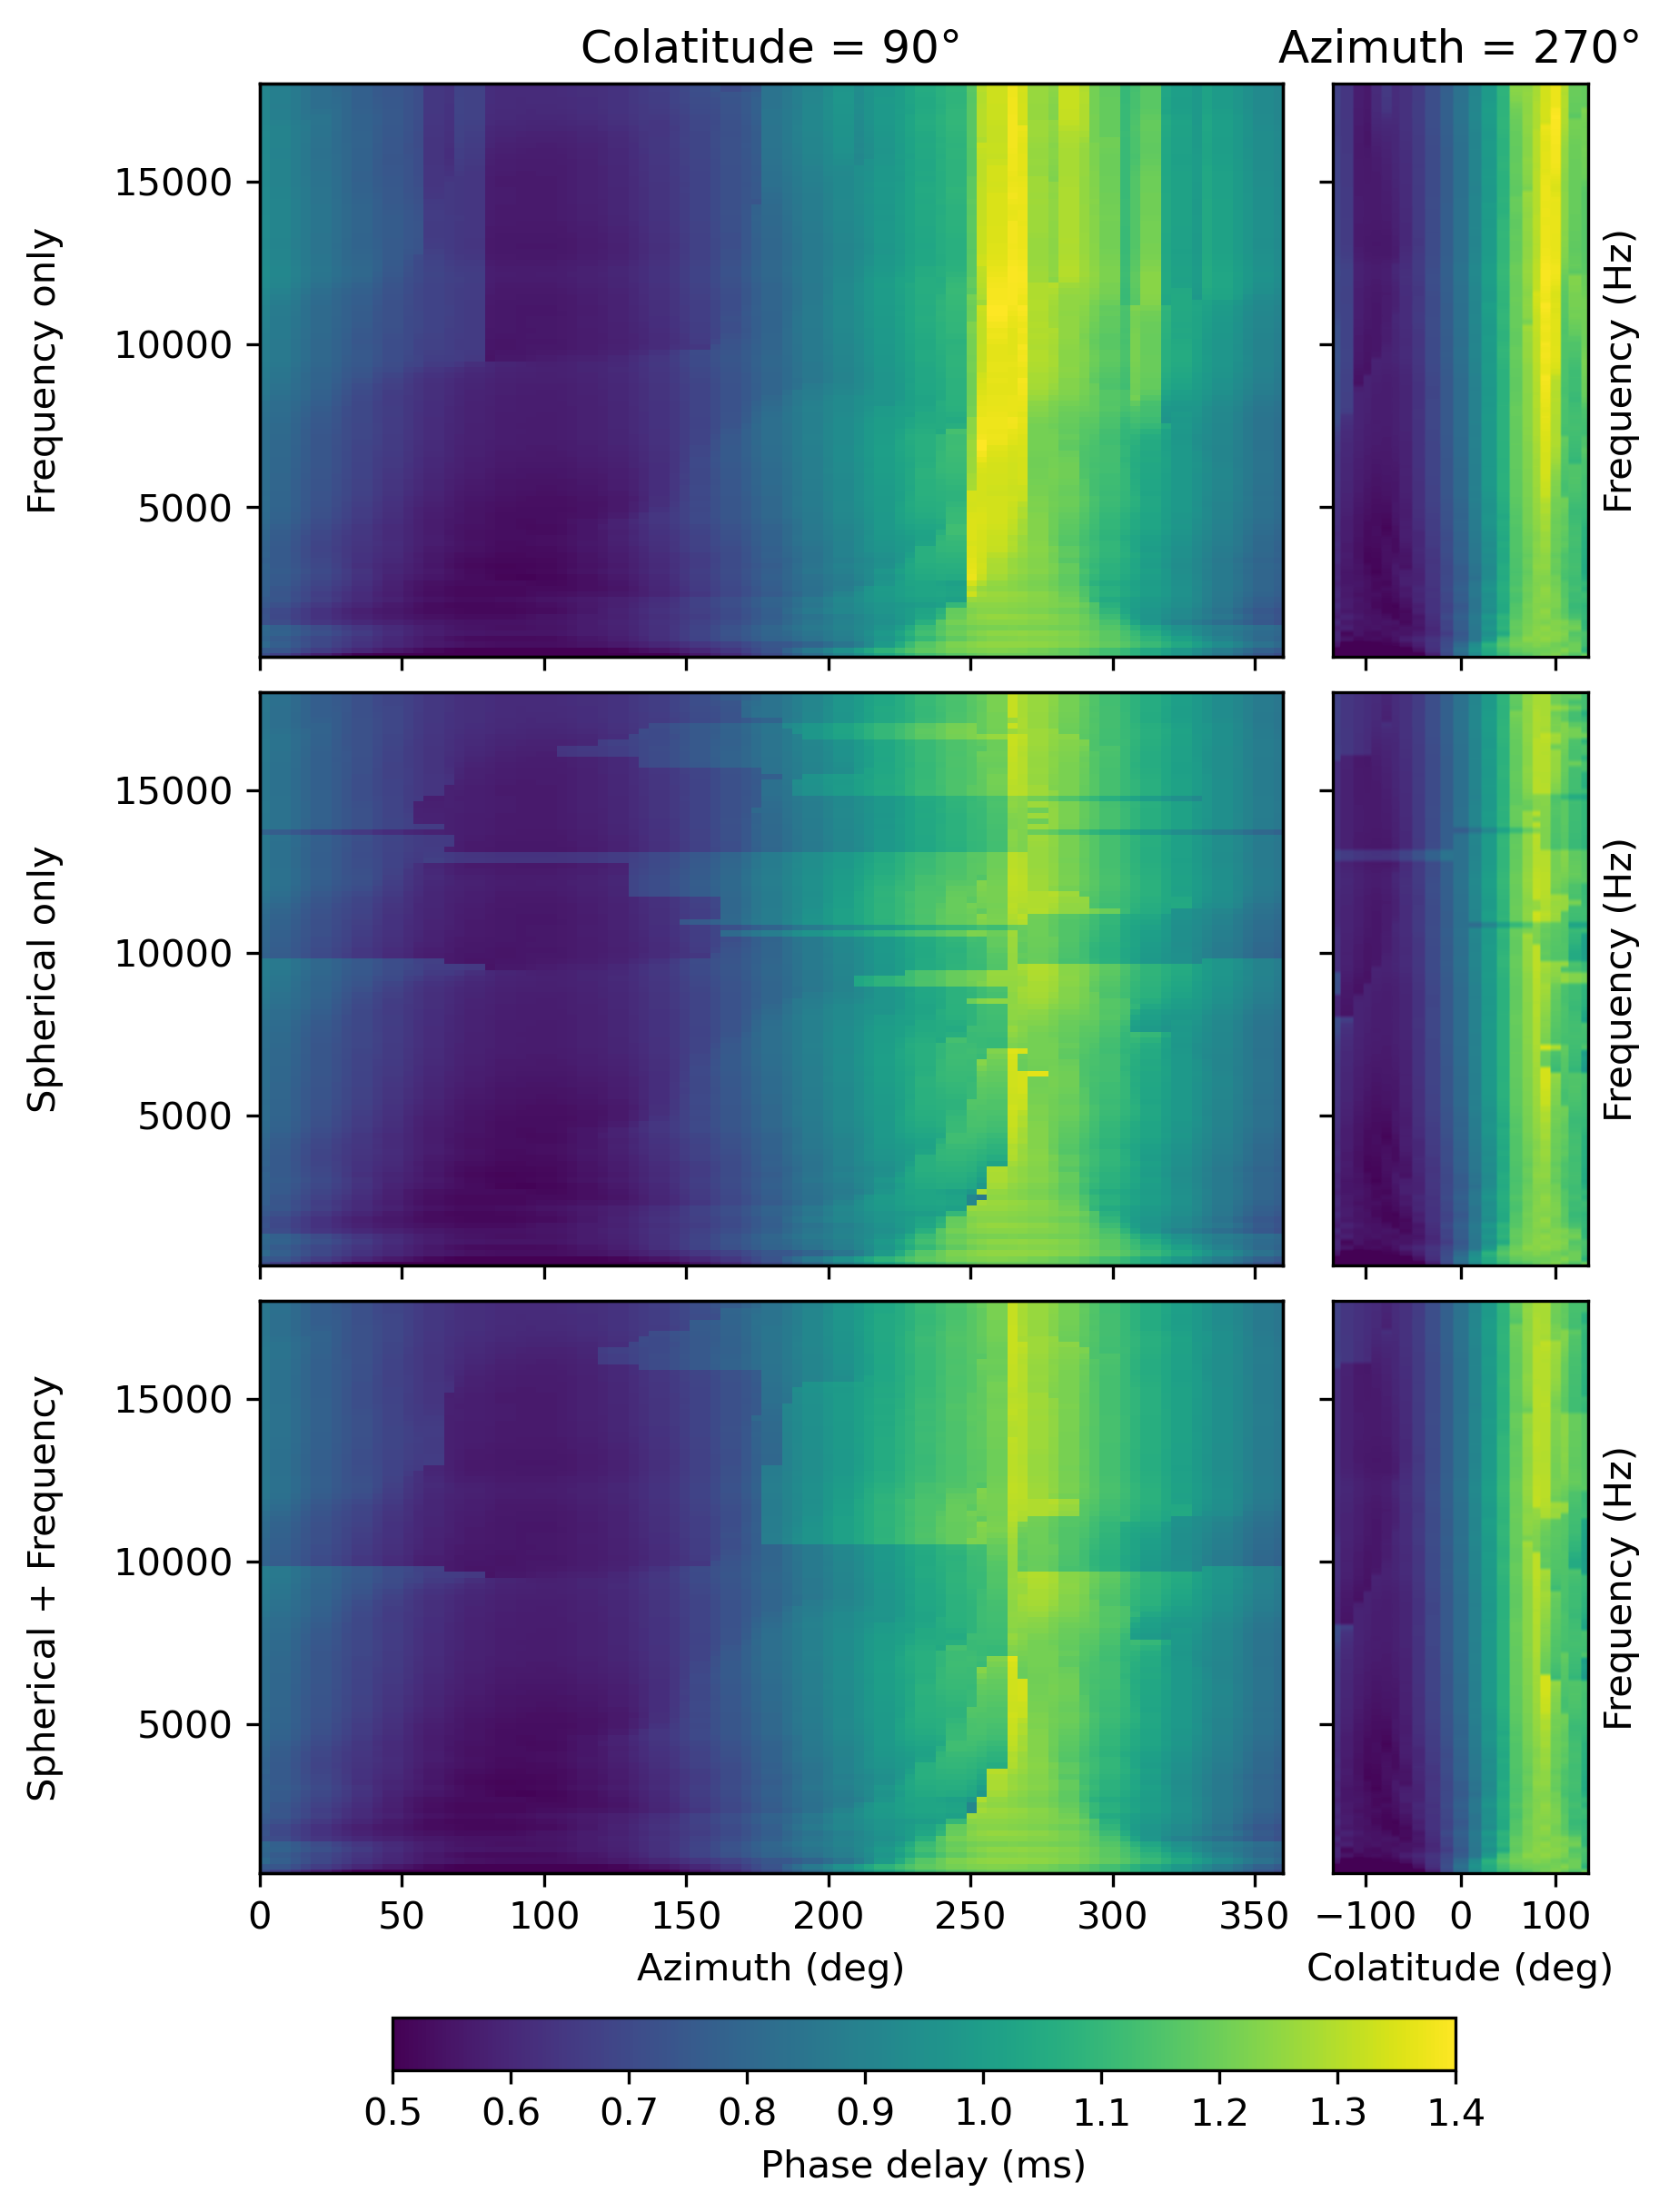

In [8]:
phase_delays = {
    k: phase2delay(v[:, 1:], freqs[1:], sr) / sr * 1000 for k, v in results.items()
}

max_col = np.max(col) * 180 / np.pi


vmax = 1.4
vmin = 0.5
extent = [0, 360, 0, sr / 2]
extent_lat = [-max_col, max_col, freqs[1], freqs[-1]]

fig, ax = plt.subplots(
    3,
    2,
    sharey=True,
    sharex="col",
    dpi=300,
    layout="constrained",
    figsize=(6, 8),
    width_ratios=[4, 1],
)

ax[0, 0].set_title("Colatitude = 90°")
ax[0, 1].set_title("Azimuth = 270°")

ax[2, 0].set_xlabel("Azimuth (deg)")
ax[2, 1].set_xlabel("Colatitude (deg)")

for i, j in product(range(3), range(2)):
    if i == 0:
        label = "Frequency only"
        k = "freqs"
    elif i == 1:
        label = "Spherical only"
        k = "spherical"
    else:
        label = "Spherical + Frequency"
        k = "spherical_freqs"

    if j == 0:
        plot_plane(
            ax[i, j],
            az,
            col,
            phase_delays[k],
            target_col=90,
            tol=1,
            vmin=vmin,
            vmax=vmax,
            extent=extent,
        )
        twin_ax = ax[i, j].twinx()
        twin_ax.annotate(
            label,
            xy=(0, 0.5),
            xytext=(-ax[i, j].yaxis.labelpad - 5, 0),
            xycoords=ax[i, j].yaxis.label,
            textcoords="offset points",
            ha="right",
            va="center",
            rotation=90,
        )
        twin_ax.set_yticks([])

    else:
        ax[i, j].set_ylabel("Frequency (Hz)")
        ax[i, j].yaxis.set_label_position("right")
        plot_lateral_plane(
            ax[i, j],
            az,
            col,
            phase_delays[k],
            target_az=270,
            tol=1,
            vmin=vmin,
            vmax=vmax,
            extent=extent_lat,
            max_col=max_col,
        )

fig.colorbar(
    cm.ScalarMappable(norm=cm.colors.Normalize(vmin=vmin, vmax=vmax)),
    ax=ax[-1],
    orientation="horizontal",
    shrink=0.8,
    # format="%.f ms",
    label="Phase delay (ms)",
)
ax[0, 0].set_ylim(400, 18000)
ax[1, 0].set_ylim(400, 18000)
plt.show()

## Phase delays distortion

Corresponding to Figure 5 in the AES paper.

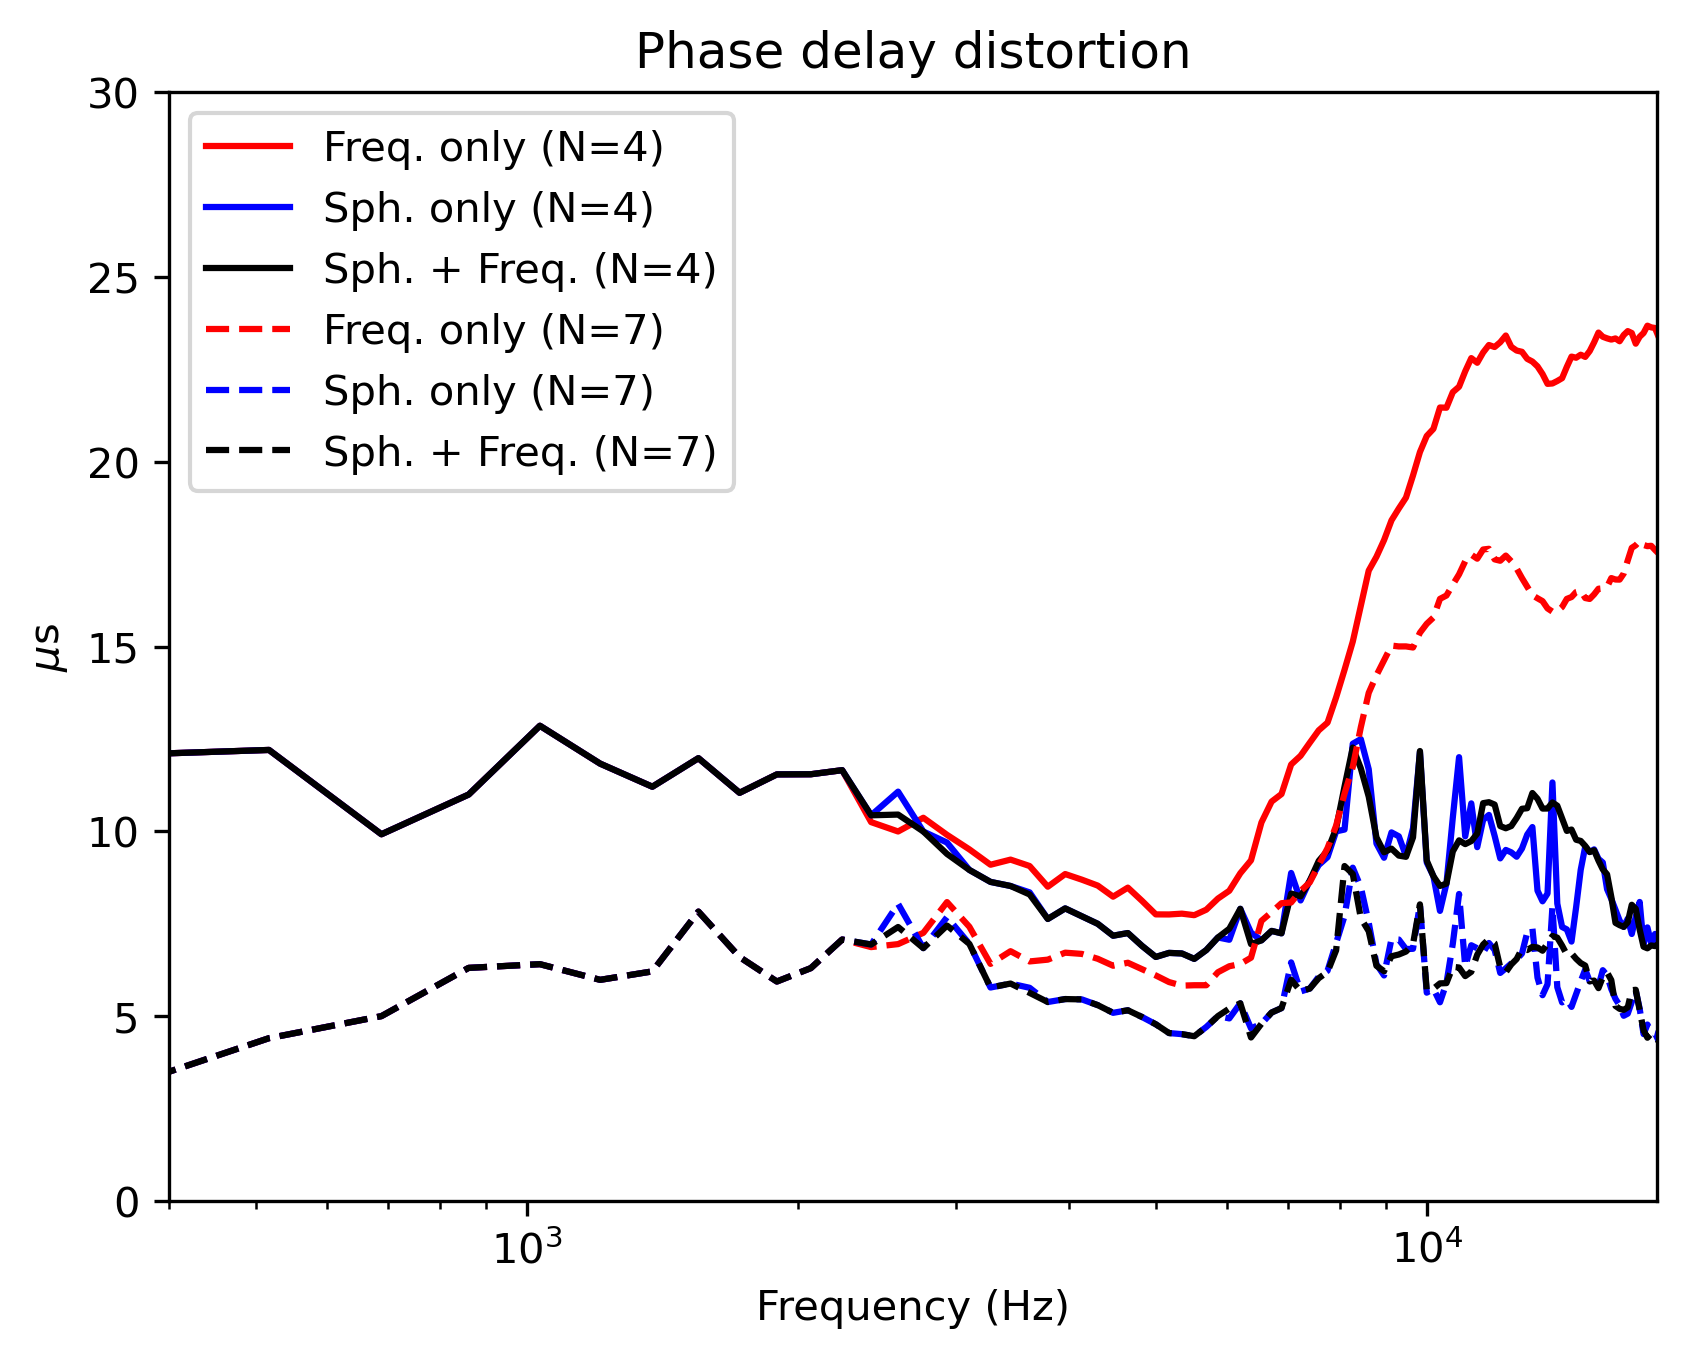

In [9]:
orders = [4, 7]
lines = ["-", "--"]

delay_recon = lambda delay, N: inverse_sht(
    sht_lstsq_reg(delay, N, az, col, "real", eps=1e-5),
    az,
    col,
    "real",
)

key2label = {
    "freqs": "Freq. only",
    "spherical": "Sph. only",
    "spherical_freqs": "Sph. + Freq.",
}

key2color = {
    "freqs": "red",
    "spherical": "blue",
    "spherical_freqs": "black",
}

fig = plt.figure(dpi=300)
plt.title("Phase delay distortion")
for (N, line_style), k in product(zip(orders, lines), results.keys()):
    # print(f"Order {N} for {k}")
    label = key2label[k] + f" (N={N})"
    delay = phase_delays[k]
    recon = delay_recon(delay, N)

    diff = np.abs(recon - delay) * 1000
    mu, std = np.mean(diff, 0), np.std(diff, 0)

    plt.plot(freqs[1:], mu, label=label, linestyle=line_style, color=key2color[k])

plt.xscale("log")
plt.xlim(400, 18000)
plt.ylim(0, 30)
plt.ylabel("$\mu$s")
plt.xlabel("Frequency (Hz)")
plt.legend()
plt.show()